In [25]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import binned_statistic
import h5py
import gc

In [2]:
snapshot = 99
cvoxels = 1024
pvoxels = 32
sim_boxsize = 205 # Mpc/h

sim_data = 'dark_matter_only'
data_dir = '/cosma7/data/dp004/dc-beck3/Dark2Light/data/%s/' % sim_data
sim_label = 'full_physics'
label_dir = '/cosma7/data/dp004/dc-beck3/Dark2Light/data/%s/' % sim_label

train_data_file = data_dir + '%s_s%d_v%d_dm_train.h5' % (sim_data, snapshot, cvoxels)
train_label_file = label_dir + '%s_s%d_v%d_dm_train.h5' % (sim_label, snapshot, cvoxels)

valid_data_file = data_dir + '%s_s%d_v%d_dm_valid.h5' % (sim_data, snapshot, cvoxels)
valid_label_file = label_dir + '%s_s%d_v%d_dm_valid.h5' % (sim_label, snapshot, cvoxels)

test_data_file = data_dir + '%s_s%d_v%d_dm_test.h5' % (sim_data, snapshot, cvoxels)
test_label_file = label_dir + '%s_s%d_v%d_dm_test.h5' % (sim_label, snapshot, cvoxels)

In [3]:
print(
    "If the simulation-box is devided into %d parent-voxels, " % (pvoxels) + \
    "the network would see a box with an edge-length of %.2f Mpc/h at a time" % (sim_boxsize/pvoxels))

If the simulation-box is devided into 32 parent-voxels, the network would see a box with an edge-length of 6.41 Mpc/h at a time


In [26]:
# load train data

def load_data(pvoxels):
    content = np.zeros((len(pvoxels.keys()), 2))
    ii = 0
    for k, v in pvoxels.items():                                                   
        content[ii, 0] = np.count_nonzero(v)
        content[ii, 1] = np.sum(v)
        ii += 1
    return content

pvoxels = h5py.File(train_data_file, "r")
train_data_content = load_data(pvoxels)
pvoxels = h5py.File(train_label_file, "r")
train_label_content = load_data(pvoxels)
train = {
    "data" : train_data_content,
    "label" : train_label_content,
}

pvoxels = h5py.File(valid_data_file, "r")
valid_data_content = load_data(pvoxels)
pvoxels = h5py.File(valid_label_file, "r")
valid_label_content = load_data(pvoxels)
valid = {
    "data" : valid_data_content,
    "label" : valid_label_content,
}

pvoxels = h5py.File(test_data_file, "r")
test_data_content = load_data(pvoxels)
pvoxels = h5py.File(test_label_file, "r")
test_label_content = load_data(pvoxels)
test = {
    "data" : test_data_content,
    "label" : test_label_content,
}

del pvoxels
gc.collect()

TypeError: data type not understood

In [21]:
print(np.min(train["data"][:,0]), np.max(train["data"][:,0]))
print(np.min(train["label"][:,0]), np.max(train["label"][:,0]))

16780.0 31897.0
17251.0 31893.0


In [14]:
# Stars
stars_filename = filename + '_st_r.npy'
stars = np.load(data_dir + stars_filename)

In [15]:
total_n_stars = np.sum(stars)
max_n_stars = np.max(stars)
mean_n_stars = np.mean(stars)

In [42]:
non_zero_stars_cells = len(np.where(stars.flatten() != 0. )[0])
percent_non_zero_stars_cells = non_zero_stars_cells/n_voxels**3


In [17]:
# Subhalos
sh_filename = filename + '_sh_r.npy'
sh = np.load(data_dir + sh_filename)

In [18]:
total_n_sh = np.sum(sh)
max_n_sh = np.max(sh)
mean_n_sh = np.mean(sh)

In [19]:
non_zero_sh_cells = len(np.where(sh.flatten() != 0. )[0])
percent_non_zero_sh_cells = non_zero_sh_cells/n_voxels**3


In [20]:
print('%.2f%% of the cells have non-zero dark matter particles'%(percent_non_zero_dm_cells * 100))
print('%.2f%% of the cells have non-zero stellar particles'%(percent_non_zero_stars_cells * 100))
print('%.2f%% of the cells have non-zero subhalos'%(percent_non_zero_sh_cells * 100))

19.34% of the cells have non-zero dark matter particles
0.05% of the cells have non-zero stellar particles
0.10% of the cells have non-zero subhalos


In [21]:
print('Total numbers:')
print('%d total dm particles'%total_n_dm)
print('%d total stellar particles'%total_n_stars)
print('%d total subhalos'%total_n_sh)

Total numbers:
134217728 total dm particles
803357 total stellar particles
143434 total subhalos


In [22]:
print('Ranges:')
print('(%d, %d) dm particles/voxel'%(0,max_n_dm))
print('(%d, %d) stellar particles/voxel'%(0,max_n_stars))
print('(%d, %d) subhalos/voxel'%(0,max_n_sh))

Ranges:
(0, 63792) dm particles/voxel
(0, 19470) stellar particles/voxel
(0, 5) subhalos/voxel


In [23]:
# Get rid of voxels with no dark matter
dm_only_full = dm_only[np.where(dm_only > 0)]
stars_full = stars[np.where(dm_only > 0)]

In [31]:
# How many stars are there in empty dark matter voxels?
stars_empty = stars[np.where(dm_only == 0)]

In [36]:
stars_full_dm_empty = len(stars_empty[stars_empty > 0])
print(f'There are {stars_full_dm_empty} voxels with no dark matter, but some stars')

There are 124 voxels with no dark matter, but some stars


In [47]:
non_zero_stars_cells_full_dm = len(np.where(stars_full > 0 )[0])

print('%d dm occupied cells have non-zero stellar particles'%(non_zero_stars_cells_full_dm))

print('%.2f%% dm occupied cells have non-zero stellar particles'%(100*non_zero_stars_cells_full_dm/len(dm_only_full)))


61801 dm occupied cells have non-zero stellar particles
0.24% dm occupied cells have non-zero stellar particles


In [54]:

flat_dm_only = dm_only.flatten()
flat_stars = stars.flatten()

bins = np.logspace(1, np.log10(max_n_dm),100)


In [55]:
# Plot percentage of empty star voxels compared to number of dark matter particles

stars_occupation = flat_stars.copy()
stars_occupation[flat_stars > 0] = 1
stars_occupation[flat_stars == 0] = 0


In [63]:
bin_means, bin_edges, binnumber = binned_statistic(dm_only.flatten(),
                    flat_stars.flatten(), bins=bins)
bin_std, bin_edges, binnumber = binned_statistic(dm_only.flatten(),
                    flat_stars.flatten(), statistic='std', bins=bins)

In [64]:
bin_center = 0.5*(bin_edges[1:] + bin_edges[:-1])

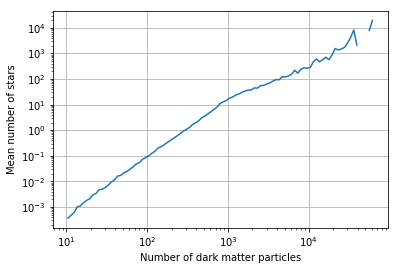

In [65]:
#minimum_dm_particles = 300

plt.loglog((bin_center), (bin_means))#, yerr = (bin_std))

#plt.errorbar(np.log10(bin_center), np.log10(bin_means), yerr = np.log10(bin_std))

#plt.axvline(x = minimum_dm_particles,
#            linestyle='dashed', color='red')
plt.xlabel('Number of dark matter particles')
plt.ylabel('Mean number of stars')
plt.grid()

In [81]:
# Plot percentage of occupied cells as function of cut

cuts = np.linspace(50,1000,100)
percent = []
cum = []
minimum_n_stars = 50

for cut in cuts:
    
    total_voxels = len(flat_dm_only[flat_dm_only > cut])
    star_occupied_voxels = flat_stars[~(flat_dm_only > cut)]
    percent.append(len(star_occupied_voxels[star_occupied_voxels > 0]))
    
    cum.append(np.sum(star_occupied_voxels[star_occupied_voxels > 0]))

Text(0.5,0,'Dark matter n particles cut')

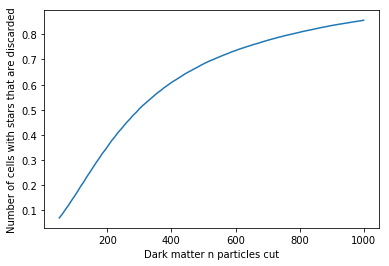

In [60]:
plt.plot(cuts, np.asarray(percent)/len(stars_occupation[stars_occupation > 0]))
plt.ylabel('Number of cells with stars that are discarded')
plt.xlabel('Dark matter n particles cut')

Text(0.5,0,'Dark matter n particles cut')

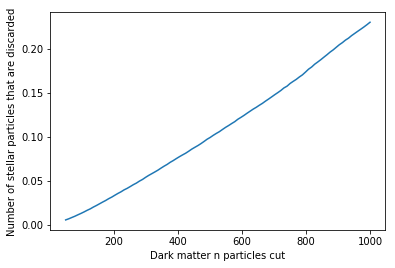

In [82]:
plt.plot(cuts, np.asarray(cum)/total_n_stars)
plt.ylabel('Number of stellar particles that are discarded')
plt.xlabel('Dark matter n particles cut')

In [70]:
minimum_n_dm = 50

dm_only_minimum = dm_only[np.where(dm_only > minimum_n_dm)]
stars_minimum = stars[np.where(dm_only > minimum_n_dm)]

In [88]:

percentage_non_empty_stars = 100 * len(stars_minimum[stars_minimum > 0])/len(dm_only_minimum)

discarded_stars = flat_stars[~(flat_dm_only > minimum_n_dm)]

print(f'There are {percentage_non_empty_stars} with stars, after selecting minimum 50 dm particles')
print(f'But only {100 * np.sum(discarded_stars)/total_n_stars} percent of the star particles are thrown away.')

There are 20.179413053000438 with stars, after selecting minimum 50 dm particles
But only 0.5544235003865031 percent of the star particles are thrown away.


In [23]:
box_size = 80 # voxels per box side
idx = np.arange(0,n_voxels,1)
start_idx_x = 50
threshold_x = (idx > start_idx_x) & (idx < start_idx_x + box_size)
start_idx_y = 300
threshold_y = (idx > start_idx_y) & (idx < start_idx_y + box_size)
start_idx_z = 70
threshold_z = (idx > start_idx_z) & (idx < start_idx_z + box_size)


In [24]:
# Plot one of the boxes (32 voxels)
dm_box_projection = dm_only[threshold_x,:,:]
dm_box_projection = dm_box_projection[:,threshold_y,:]
dm_box_projection = np.sum(dm_box_projection[:,:,threshold_z],axis=-1)

In [25]:
xlabels_pos = np.arange(0,box_size,40)
xlabels = np.round(xlabels_pos * voxel_size, decimals=2)

In [26]:
reference_box = np.zeros_like(dm_box_projection)

In [27]:
reference_box[:32,32] = np.ones(32)
reference_box[32,:32] = np.ones(32)

In [28]:
star_box_projection = stars[threshold_x,:,:]
star_box_projection = star_box_projection[:,threshold_y,:]
star_box_projection = np.sum(star_box_projection[:,:,threshold_z],axis=-1)

In [29]:
sh_box_projection = sh[threshold_x,:,:]
sh_box_projection = sh_box_projection[:,threshold_y,:]
sh_box_projection = np.sum(sh_box_projection[:,:,threshold_z],axis=-1)

/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


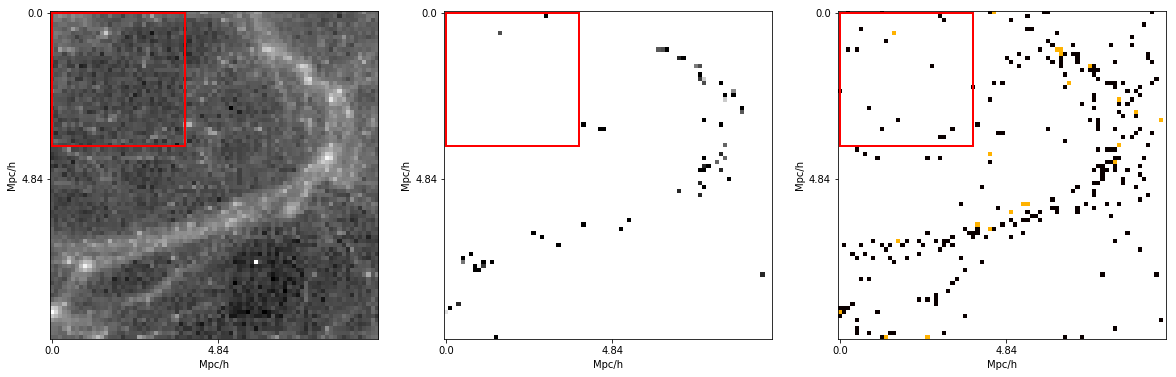

In [30]:
fig,axes = plt.subplots(1,3, figsize=(20,60))
boxes_to_show = [dm_box_projection, star_box_projection, sh_box_projection]
cmaps = ['gray', 'gray', 'hot']
for i, ax in enumerate(axes):
    
    #if(i==0):
    ax.imshow(np.log10(boxes_to_show[i]), cmap=cmaps[i])
    #else:
    #    ax.imshow((boxes_to_show[i]), cmap=cmaps[i])


    rect = patches.Rectangle((0,0),32,32,linewidth=2,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.set_xticks(xlabels_pos)
    ax.set_xticklabels(xlabels)
    ax.set_yticks(xlabels_pos)
    ax.set_yticklabels( xlabels)
    ax.set_xlabel('Mpc/h')
    ax.set_ylabel('Mpc/h')
    

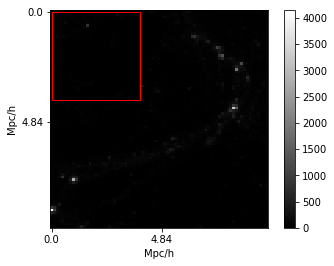

In [31]:
fig,ax = plt.subplots(1)

im = ax.imshow((boxes_to_show[0]), cmap='gray')

rect = patches.Rectangle((0,0),32,32,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xticks(xlabels_pos)
ax.set_xticklabels(xlabels)
ax.set_yticks(xlabels_pos)
ax.set_yticklabels( xlabels)
ax.set_xlabel('Mpc/h')
ax.set_ylabel('Mpc/h')
fig.colorbar(im)

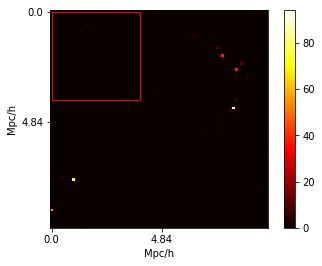

In [32]:
fig,ax = plt.subplots(1)

im = ax.imshow((boxes_to_show[1]), cmap='hot')

rect = patches.Rectangle((0,0),32,32,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xticks(xlabels_pos)
ax.set_xticklabels(xlabels)
ax.set_yticks(xlabels_pos)
ax.set_yticklabels( xlabels)
ax.set_xlabel('Mpc/h')
ax.set_ylabel('Mpc/h')
fig.colorbar(im)

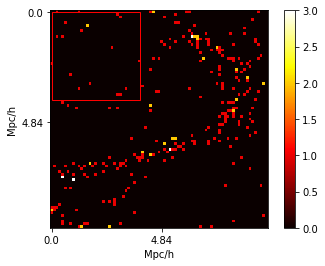

In [33]:
fig,ax = plt.subplots(1)

im = ax.imshow((boxes_to_show[-1]), cmap='hot')

rect = patches.Rectangle((0,0),32,32,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xticks(xlabels_pos)
ax.set_xticklabels(xlabels)
ax.set_yticks(xlabels_pos)
ax.set_yticklabels( xlabels)
ax.set_xlabel('Mpc/h')
ax.set_ylabel('Mpc/h')
fig.colorbar(im)